# Measuring Bias in a Multiclass Classification Model

In this notebook, we audit a multiclass classification system for bias using the holisticai library. We will load and explore a dataset, train a multiclass classification model, and audit the model using the library's bias metrics. All questions and tasks are bolded and in red.

### 0 - Importing modules and loading the data

We begin by importing necessary modules and loading the dataset. For this milestone, we will be using the 'Student Performance Dataset' from the UC Irvine Machine Learning Repository and loading it directly from the holisticai library. The dataset captures the performance of students in two Portuguese secondary schools. 

In [ ]:
# make sure you have holisticai library installed
!pip install holisticai

In [1]:
# Base Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score

# import dataset
from holisticai.datasets import load_student

# import plotting functions
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.plots import frequency_plot

# import some bias metrics
from holisticai.bias.metrics import multiclass_statistical_parity
from holisticai.bias.metrics import multiclass_equality_of_opp
from holisticai.bias.metrics import confusion_matrix

In [2]:
# load dataset into a dataframe
df = load_student()['frame']

### 1- Exploring the dataset

Now that we've loaded the data, let's explore it using pandas.

In [3]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,...,4.0,3.0,4.0,1.0,1.0,3.0,6.0,5.0,6.0,6.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,...,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5.0,5.0,6.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,...,4.0,3.0,2.0,2.0,3.0,3.0,10.0,7.0,8.0,10.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,...,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15.0,14.0,15.0
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,...,4.0,3.0,2.0,1.0,2.0,5.0,4.0,6.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20.0,U,LE3,A,2.0,2.0,services,services,...,5.0,5.0,4.0,4.0,5.0,4.0,11.0,9.0,9.0,9.0
391,MS,M,17.0,U,LE3,T,3.0,1.0,services,services,...,2.0,4.0,5.0,3.0,4.0,2.0,3.0,14.0,16.0,16.0
392,MS,M,21.0,R,GT3,T,1.0,1.0,other,other,...,5.0,5.0,3.0,3.0,3.0,3.0,3.0,10.0,8.0,7.0
393,MS,M,18.0,R,LE3,T,3.0,2.0,services,other,...,4.0,4.0,1.0,3.0,4.0,5.0,0.0,11.0,12.0,10.0


In [4]:
df.columns.values

array(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'G3'], dtype=object)

From the previous two cells, we see that there are 395 data points and 33 attributes. There are several sensitive attributes in the data including 'sex', 'address', 'Mjob' (mother's job), and 'Fjob' (father's job). The last three attributes, G1, G2 and G3, are the level the student achieved in periods 1,2 and 3 respectively. We will now split the 'G3' value into 4 buckets to create categories to train a multiclass classification model. If the value of 'G3' is in the range [0,8), we assign the target 'very-low', if it is in the range  [8,11) we assign 'low', if it is in the range [11,14) we assign 'high', and if it is greater than or equal to 14 we assign 'very-high'. After mapping the grades to these values, we drop the 'G1','G2','G3' columns from the data.

In [5]:
# Make data multiclass by slicing into 4 buckets
y = df['G3'].to_numpy()
buckets = np.array([8, 11, 14])
y_cat = (y.reshape(-1, 1) > buckets.reshape(1, -1)).sum(axis=1)
df['target'] = y_cat

# map dictionary
grade_dict = {0:'very-low', 1:'low', 2:'high',3:'very-high'}
df['target'] = df['target'].map(grade_dict)

# drop the other grade columns
df = df.drop(columns=['G1','G2','G3'])

df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,target
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,...,no,no,4.0,3.0,4.0,1.0,1.0,3.0,6.0,very-low
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,...,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,4.0,very-low
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,...,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,10.0,low
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,...,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,2.0,very-high
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,...,no,no,4.0,3.0,2.0,1.0,2.0,5.0,4.0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20.0,U,LE3,A,2.0,2.0,services,services,...,no,no,5.0,5.0,4.0,4.0,5.0,4.0,11.0,low
391,MS,M,17.0,U,LE3,T,3.0,1.0,services,services,...,yes,no,2.0,4.0,5.0,3.0,4.0,2.0,3.0,very-high
392,MS,M,21.0,R,GT3,T,1.0,1.0,other,other,...,no,no,5.0,5.0,3.0,3.0,3.0,3.0,3.0,very-low
393,MS,M,18.0,R,LE3,T,3.0,2.0,services,other,...,yes,no,4.0,4.0,1.0,3.0,4.0,5.0,0.0,low


Let's look at the distrubtion of groups using some of the plotting functions in the holisticai library. We will begin by looking at the distrubution of newly crated 'target' column to get an idea of how the grades are distributed, then we will look at the distribution of some sensitive attributes.

<AxesSubplot:xlabel='target', ylabel='Probability'>

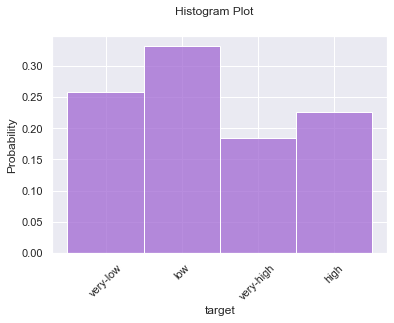

In [6]:
# show distribution of target classes with a histogram
histogram_plot(df['target'])

The pie chart below shows the distribution ofthe different jobs students' Mothers have (Mjob) in the data. We can also look at the distribution of grades amongst different Mjob values using the frequency_matrix plot shown below. From the plot we observe students with a mother working in health have the highest percentage in the 'very-high' compared to any other job.

<AxesSubplot:xlabel='Class', ylabel='Group'>

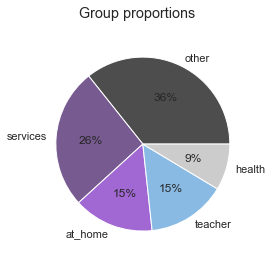

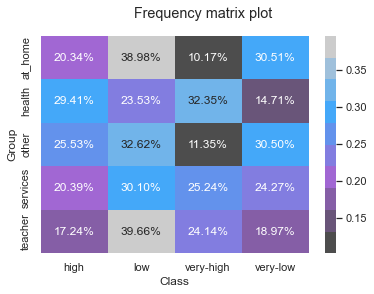

In [7]:
# use the pie plot function to explore the balance of 'Mjob' attribute
group_pie_plot(df['Mjob'])

# frequency matrix of mothers' jobs and grade groups
frequency_matrix_plot(df['Mjob'], df['target'], normalize='group')

<font color='red'>  **Task 1**
- **Create a pie plot, and a frequency matrix plot for the 'Fjob' attribute.**
<font >

<AxesSubplot:xlabel='Class', ylabel='Group'>

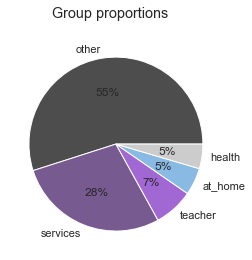

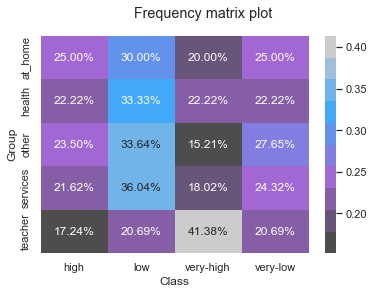

In [8]:
group_pie_plot(df['Fjob'])
# frequency matrix of address and grade groups
frequency_matrix_plot(df['Fjob'], df['target'], normalize='group')

<font color='red'> **Question 1**
- **What does the frequency matrix plot tell you about the distribution of grades among the jobs student's fathers have?**
<font > 

Answer: The students with fathers who are teachers make up a significant percentage of the 'very-high' group compared to any other occupation.

### 2 - Pre-processing the data and training the model

In this next section, we are going to prepare the data for the training of a multiclass classification model. We will use sklearn's Random Forest Classifier as our model of choice, and use its train_test_split function to split our dataset. Note, we do not want to include protected attributes in the training so we will remove 'sex', 'address', 'Mjob', and 'Fjob' from the features during training and inference. For the attributes we want to train the model on, we use one-hot encoding for each of them. After training, we will evaluate the model's performance overall and then audit it for bias.

In [9]:
# we don't want to encode protected attributes
protected_attributes = ['sex', 'address', 'Mjob', 'Fjob']
label_attributes = ['target']

# preprocess categorical columns
def preprocess_data(data, protected_attributes, label_attributes):
    categoricals = []
    for col in data.columns:
        if col not in protected_attributes and col not in label_attributes and data[col].dtype == object:
            categoricals.append(col)

    cat_encoder = OneHotEncoder()  
    enc = cat_encoder.fit_transform(data[categoricals])
    enc = pd.DataFrame(enc.toarray())
    df = pd.concat([data,enc],axis=1).drop(columns=categoricals) # add encoded columns
    df = df.rename(str, axis='columns')
    return df

# Load, preprocess and split for training
preproc_data = preprocess_data(df, protected_attributes, label_attributes)
train, test = train_test_split(preproc_data, test_size=0.4, random_state=42)

# set up data for training
X_train = train.drop(columns=label_attributes)
X_test = test.drop(columns=label_attributes)
y_train = train['target']
y_test = test['target']


# Train a simple Random Forest Classifier
model = RandomForestClassifier(random_state=111)
model.fit(X_train.drop(columns=protected_attributes), y_train)

# Predict values
y_pred = model.predict(X_test.drop(columns=protected_attributes))

Now we can use the metrics from the holisticai library to evaluate the models performance. First we will establish the distribution of the classes to get a baseline to compare our metrics to and then we will calculate accuracy, precision, recall and the confusion matrix.

In [10]:
print(y_test.value_counts())
print('Zero Rate Classification Accuracy:', round(max(y_test.value_counts())/y_test.value_counts().sum(),3))

low          47
very-low     47
high         33
very-high    31
Name: target, dtype: int64
Zero Rate Classification Accuracy: 0.297


In the cell above we find the ZeroR classification accuracy (the accuracy of predicting the most common class), to be approximately 30%. Since the classes aren't perfectly balance, we take the ZeroR as our baseline as opposed to guessing each class with 25% probability. Ideally the model should achieve a higher accuracy than this for it to be useful for the problem.

In [11]:
# evaluate models performance
print ('Accuracy:', np.round(accuracy_score(y_test, y_pred),3))
print()
print ('Precision Scores by Group:')
print('\n'.join('{}: {}'.format(*k) for k in zip(['very-low','low','high','very-high'],np.round(precision_score(y_test, y_pred, average=None, labels=['very-low','low','high','very-high']),3))))
print()
print ('Recall Scores by Group:')
print('\n'.join('{}: {}'.format(*k) for k in zip(['very-low','low','high','very-high'],np.round(recall_score(y_test, y_pred, average=None, labels=['very-low','low','high','very-high']),3))))
print()
confusion_matrix(y_pred, y_test, classes=['very-low','low','high','very-high'])

Accuracy: 0.418

Precision Scores by Group:
very-low: 0.72
low: 0.386
high: 0.235
very-high: 0.5

Recall Scores by Group:
very-low: 0.383
low: 0.681
high: 0.242
very-high: 0.258



,very-low,low,high,very-high
very-low,18.0,4.0,1.0,2.0
low,19.0,32.0,22.0,10.0
high,7.0,8.0,8.0,11.0
very-high,3.0,3.0,2.0,8.0


Using the 'very-low' category as an example, the precision measures the percentage of students correctly predicted as 'very-low' out of all predicted as 'very-low, while recall measures the percentage of correct 'very-low' predictions out of all actual 'very-low' labels (True Positive Rate). For both, the ideal value is 1. In the confusion matrix, the columns represent the ground-truth label of the datapoint and the rows represent the prediction. The diagonals of the matrix represent the correctly predicted entries. In the first column, 18 'very-low' points were correctly predicted, while 19 were incorrectly predited as 'low', 7 as 'high', and 3 as 'very-high'. In the first row, 4 'low', 1 'high' and 2 'very-high' points were incorrectly predicted as 'very-low'.

### 3 - Measuring bias
In this section, we will audit our model for bias using a number of metrics. We will investigate bias with respect to 'Mjob' attribute.

Before we perform the bias audit, we need to reframe our bias metrics in the context of multi-class classification. As in the binary classification case, the metrics fall under one of two groups: Equality of Outcome, and Equality of Opportunity. 

Let's consider two groups. In the binary case, Equality of Outcome is satisfied if the probability of being predicted the preferred outcome is equal for both groups, where the preferred outcome  is represented as $\hat{Y} = 1$, and belonging to an unprivileged group is represented as $A=1$. More formally, $P(\hat{Y}=1 \vert A = 0) = P(\hat{Y}=1 \vert A = 1)$, where $\hat{Y}$ is the predicted outcome, and $A$ is the group the person belongs to. In the multiclass case, the probability of predicted any class $k$ must be the same for all classes. Formalizing this, we have $P(\hat{Y}=k \vert A = 0) = P(\hat{Y}=k \vert A = 1) \ \forall \ k \in \{1,2,...,n\}$ and $n$ is the number of classes. We can measure Statistical Parity to determine how far away a classifier is from Equality of Outcome. 

For statistical parity, we create a probability vector for each group, where the vector stores the probability of predicting each class: $P(\hat{Y}=k \vert A = a_i)$, where $k$ is the predicted class and $a_i$ is the group that data point belongs to such that  $a_i \in \{a_1,a_2,...,a_m\} $ and $m$ the number of different groups in the protected attribute. We then calculate the distance between these vectors to get the statistical parity between the two groups in the multiclass case. In the event of having more than one group, we can caluclate the statistical parity for every possible pairing of groups and then aggregate the distances by either taking the mean or the maximum value. The ideal value is 0, but values below 0.1 are acceptable.


Equality of Opportunity is satisfied if the probability of *correctly* predicting an outcome is equal for both groups, for all classes. More formally, $P(\hat{Y}=k \vert A = 0,Y=k) = P(\hat{Y}=k \vert A = 1,Y=k) \ \forall \ k \in \{1,2,...,n\}$, $\hat{Y}$ is the predicted outcome, $A$ is the group the person belongs to, and $Y$ is the ground truth label. To compute whether or not a system satisfies this condition, we can compute a matrix of error rates for each group and calculate the distance between them. Once again, if there are more than two groups we can calculate the metric for every possible pair of groups and then aggregate using the mean or maximum value.

Let's compute the statistical parity using both aggregation methods. For both cases we will see that the model shows bias with respect to the 'Mjob' attribute.

In [12]:
# set up vectors
p_attr = test['Mjob']                                               # protected attribute
y_pred = model.predict(X_test.drop(columns=protected_attributes))   # multiclass prediction vector
y_true = y_test                                                     # multiclass label vector


# Mean Statsitical Parity
print('Mean Statsitical Parity:', round(multiclass_statistical_parity(
    p_attr, y_pred, aggregation_fun="mean"
),3))

# Max Statsitical Parity
print('Max Statsitical Parity:', round(multiclass_statistical_parity(
    p_attr, y_pred, aggregation_fun="max"
),3))

Mean Statsitical Parity: 0.147
Max Statsitical Parity: 0.278


We can do the same for Equality of Opportunity, and we see simialr results.

In [13]:
print('Mean Equality of Opportunity:', round(multiclass_equality_of_opp(
    p_attr, y_pred, y_true, aggregation_fun="mean"
),3))


Mean Equality of Opportunity: 0.342


In [14]:
print('Mean Equality of Opportunity:', round(multiclass_equality_of_opp(
    p_attr, y_pred, y_true, aggregation_fun="max"
),3))


Mean Equality of Opportunity: 0.469


Now that you've seen how to set up the data to measure bias, your task will be to assess the model's bias with respect to the 'Fjob' attribute. In the cells below, follow the procedure for measuring bias using the holisticai library and functions.

<font color='red'>  **Task 2**
- **Measure the 'mean' and 'max' Statistical Parity, and Equality of Opportunity metrics for the 'Fjob' attribute.**
<font >

In [27]:
# set up vectors for address

# set up vectors
p_attr = test['Fjob']                                               # protected attribute
y_pred = model.predict(X_test.drop(columns=protected_attributes))   # multiclass prediction vector
y_true = y_test                                                     # multiclass label vector

print('SP Mean:', round(multiclass_statistical_parity(
    p_attr, y_pred, aggregation_fun="mean"
),3))

print('SP Max:', round(multiclass_statistical_parity(
    p_attr, y_pred, aggregation_fun="max"
),3))

print('EO Mean:', round(multiclass_equality_of_opp(
    p_attr, y_pred, y_true, aggregation_fun="mean"
),3))

print('EO Max:', round(multiclass_equality_of_opp(
    p_attr, y_pred, y_true, aggregation_fun="max"
),3))



SP Mean: 0.242
SP Max: 0.337
EO Mean: 0.414
EO Max: 0.562


You should get the following results:

| Metric | Value | Reference |
| --- | --- | --- |
| Statistical Parity Mean      | 0.242 | 0 |
| Statistical Parity Max       | 0.337 | 0 |
| Equality of Opportunity Mean | 0.414 | 0 |
| Equality of Opportunity Max  | 0.562 | 0 |




<font color='red'>  **Question 2**
- **Is the model biased? Comment on the model's performance with respect to the protected attribute.**
<font >

Answer: Students whose fathers stay at home are predicted to be in the 'very-low' class significantly more than any other group and can be seen using the frequency matrix plot.

<AxesSubplot:xlabel='Class', ylabel='Group'>

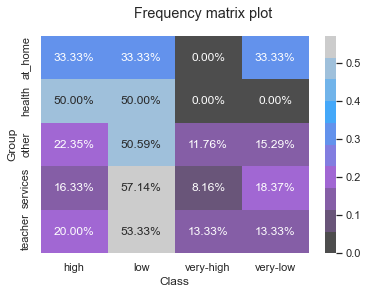

In [28]:
frequency_matrix_plot(p_attr, y_pred, normalize='group')